# Import

In [1]:
%load_ext autoreload
%autoreload 2
import re
import ast
import numpy as np
import json
import seaborn as sns
from scipy import stats
%matplotlib inline
from utils import *

# CMU DATASET ANALYSIS

In [2]:
DATA_FOLDER = './datasets/'

In [3]:
# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB',
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name',
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER+'CMU_dataset/character.metadata.tsv', names=columns_char,
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])

# Loading movies
columns_mov = ['Wikipedia_Movie_ID','Freebase_Movie_ID','Movie_name','Movie_release_date',
          'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
          'Movie_genres']

cmu_df = pd.read_table(DATA_FOLDER+'CMU_dataset/movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

The goal of our study is to analyze what factors contribute to the success of a movie. Let us first have a quick analysis on our provided data set.


In [4]:
plot_missing_values_percentage(characters)

AttributeError: 'DataFrame' object has no attribute 'map'

In [5]:
plot_missing_values_percentage(cmu_df)

AttributeError: 'DataFrame' object has no attribute 'map'

**Comment:** Good factors to measure the success of a movie are its ratings and its revenues. We can see that our data set does not contain any information on movie ratings, and has a very high percentage of missing values for the movie revenues.
**Solution:** Merge the CMU dataset with our additional dataset that contains ratings informations and additional box office revenues

### Creating a mapping between the IMDB Id and the Freebase_Movie_ID

In [6]:
data = query_wikidata()

In [7]:
imbd_freebase = json_to_df(data)

In [8]:
imbd_freebase.drop_duplicates(subset=['imdb_id','freebase_id'], inplace=True)

# 2. TMBD Analysis

In [9]:
pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')

C:\Users\mathr\AppData\Local\Temp\ipykernel_14556\885709851.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')


### Drop Non-related Columns

In [10]:
pd_tmbd = pd_tmbd.drop(['adult', 'belongs_to_collection',  'homepage', 'original_title', 'overview', 'poster_path', 'status', 'tagline', 'video'], axis=1)

#### Evaluate the literal value to convert it to array

In [11]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: safe_literal_eval(x))

#### Convert the initial dictonnaries into array of items

In [12]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: get_names(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: get_names(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: get_names(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: get_names(x))

### Merging the CMU and the TMDB Datasets

In [13]:
cmu_df = pd.merge(left=cmu_df, right=imbd_freebase, right_on='freebase_id', left_on='Freebase_Movie_ID', how='inner').drop(columns='freebase_id')

In [14]:
movies = pd.merge(right=cmu_df, left=pd_tmbd, on='imdb_id', how='inner').drop_duplicates(subset='imdb_id')

In [15]:
len(movies)

27423

### Box Office Revenue Data Consolidation

In [16]:
movies['revenue'].replace(0.0, np.nan, inplace=True)
movies['Movie_box_office_revenue'].replace(0.0, np.nan, inplace=True)

In [17]:
movies['revenue'] = movies['revenue'].fillna(movies['Movie_box_office_revenue'])
movies['Movie_box_office_revenue'] = movies['Movie_box_office_revenue'].fillna(movies['revenue'])
movies.drop(columns='revenue', inplace=True)

### Preprocessing the genres, languages and countries columns

**Comment:** We have the columns mentioned above are represented as dictionaries with key freebase_id and values country names, genres and languages of the movie with id freebase_id, that's why we decided to retrieve the values and store them instead of having the dictionary representation

In [18]:
movies['Movie_genres'] = movies['Movie_genres'].apply(transform_row)
movies['Movie_countries'] = movies['Movie_countries'].apply(transform_row)
movies['Movie_languages'] = movies['Movie_languages'].apply(transform_row)

In [19]:
movies.drop(columns=['Wikipedia_Movie_ID','Movie_release_date', 'title', 'runtime', 'original_language', 'production_companies','id'], axis=1, inplace=True)

### First stage analysis of the impact of the production countries

One of our subquestions is to understand and analyse factors that influence the success of a movie. One of these such factors is the country of production (It's the country where the movie was released). We might think that a movie may be more or less successful depending on its production country. Let's take a look at the data to inspect this aspect.

In [20]:
movie_copy = movies.copy()

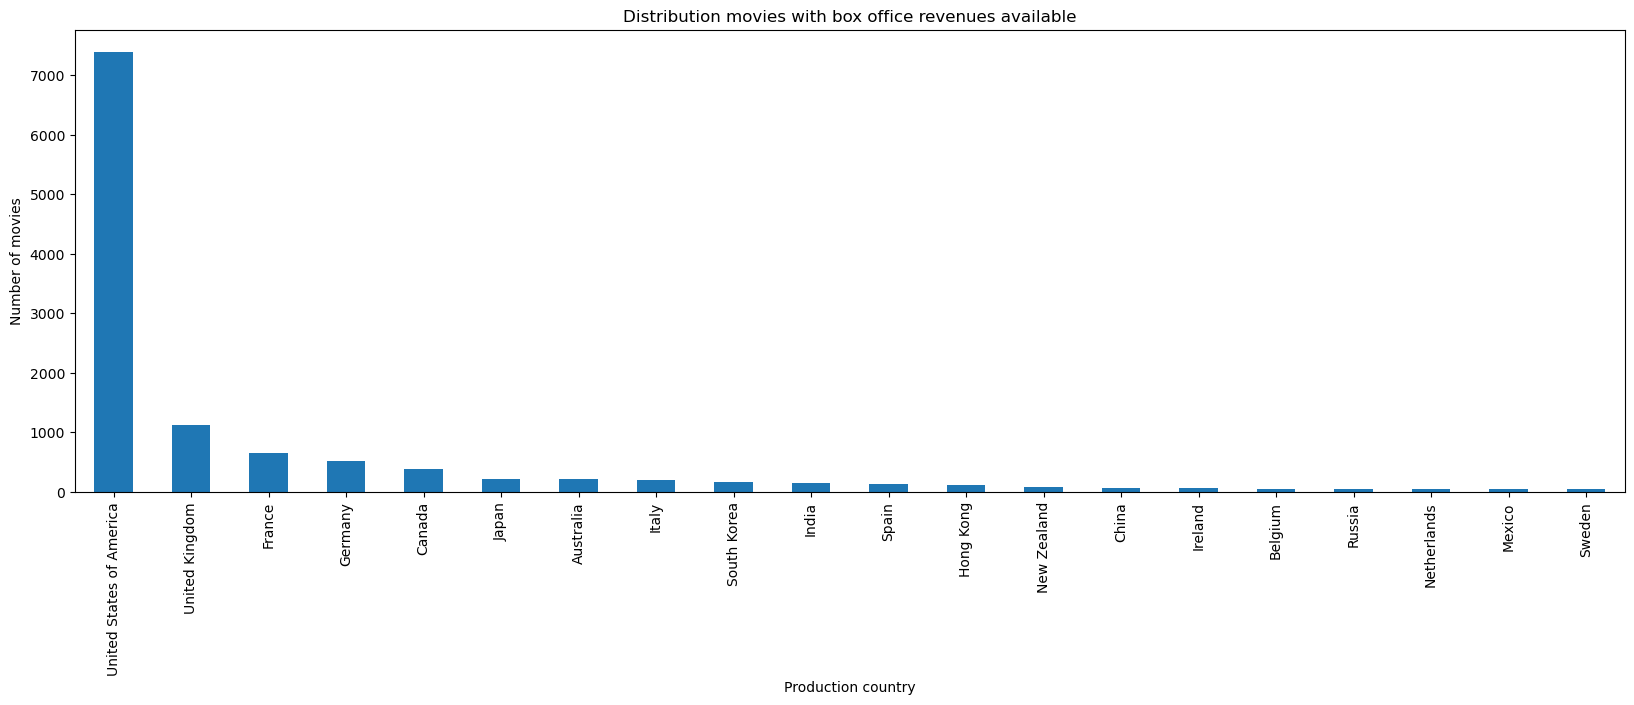

In [21]:
# Plot distribution of movies with a box office revenue
movies_with_revenues = movie_copy.dropna(subset=['Movie_box_office_revenue'])

plot_top_20_most_popular(movies_with_revenues, 'Movie_countries', 'Production country', 'Number of movies', 'Distribution movies with box office revenues available')

As we can observe, most of the movies that have information about box office revenues were produced in the United States while other countries are  under represented. Only a few data points for box office revenues are available for other countries. Therefore, to keep enough data to perform a fair and meaningful comparison, we will have to consider the average ratings as a metric for success for this particular subquestion of our analysis. 

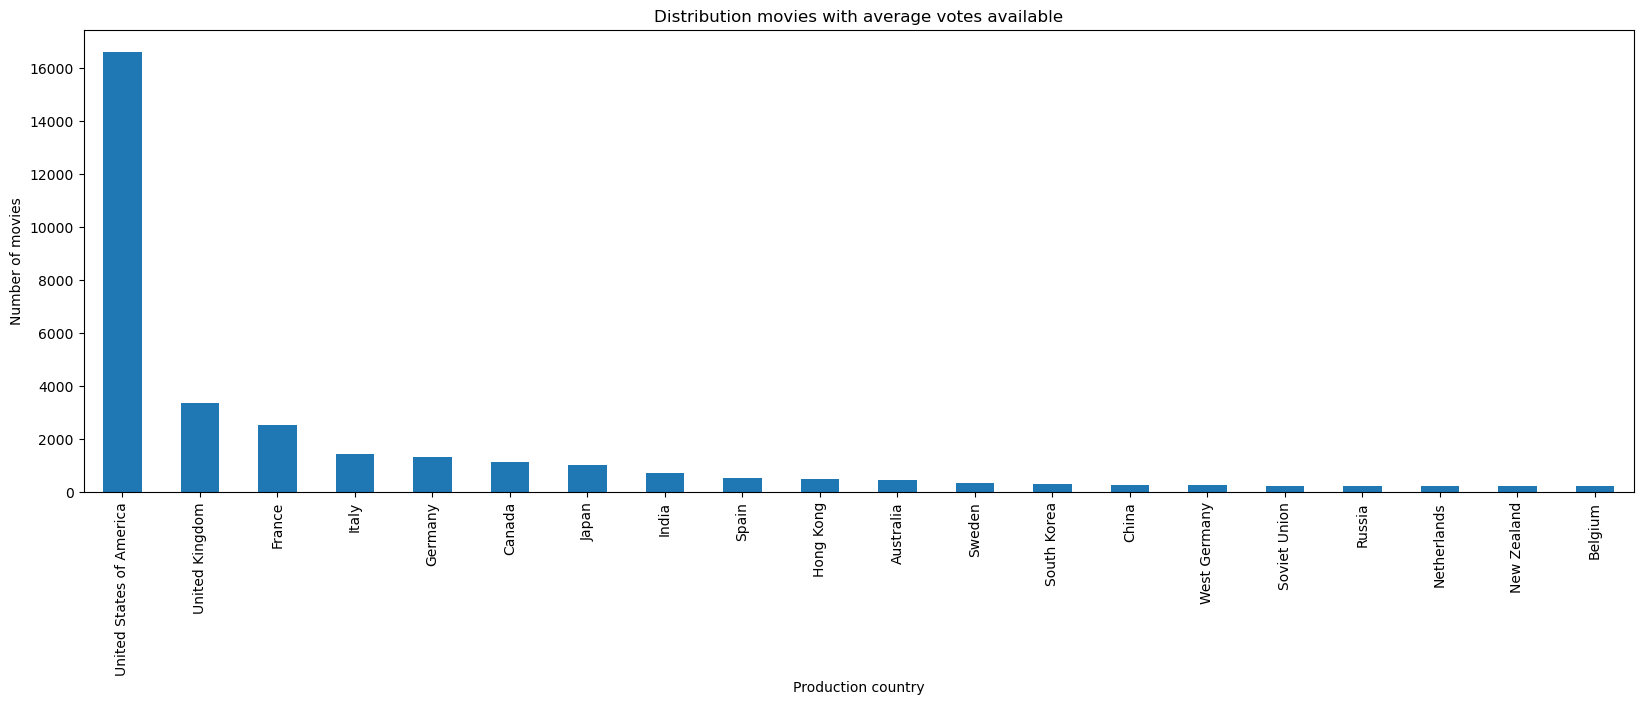

In [22]:
# Plot distribution of movies with an average vote
movies_with_vote = movie_copy.dropna(subset=['vote_average'])

plot_top_20_most_popular(movies_with_vote, 'Movie_countries', 'Production country', 'Number of movies', 'Distribution movies with average votes available')

Again the United States are still strongly represented when compared to other countries, however we observe that much more data about ratings are available for all countries compared to box office revenues enabling us to better judge how successful the movie was. There is more than two times more data available about ratings for France and the United Kingdom when compared to box office revenues. This is good news for our analysis since this will enable us to better see the affect of various factors on the movies success since we can now get a good idea of how successful each film was.

Let us take a look to the ratings in greater details. To be able to visualize our data, we will only keep the top 20 values of each feature we wish to visualize i.e. we consider the 20 most common production countries when talking about country. The same applies to movie genres when we will examine this feature and its relation with the production country.

In [23]:
# Duplicate movies with several production countries and genres

movies_expanded = movies_with_vote.explode('Movie_countries')
movies_fully_expanded = movies_expanded.explode('genres')

In [24]:
# Select the movies from the 20 most common production countries

top20_country = movies_fully_expanded['Movie_countries'].value_counts()[:20]
df_top20_country = movies_fully_expanded[movies_fully_expanded['Movie_countries'].isin(top20_country.index)]

Text(0, 0.5, 'Numbers of averge votes')

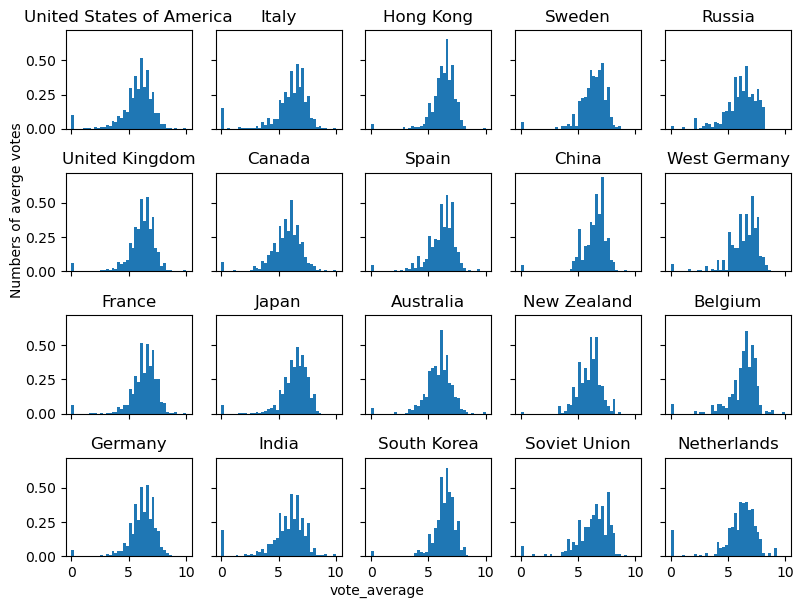

In [25]:
# Plot the distribution of the average votes for the top 20 countries

country = df_top20_country.groupby('Movie_countries')

fig, ax = plt.subplots(4,5,figsize= (8,6), sharey = True, sharex = True)

for i, name in enumerate(top20_country.index):
    sbplt = ax[i%4, i//4]
    sbplt.hist(country.get_group(name).vote_average, range = [0,10], density=True, bins = 40)
    sbplt.set_title(name)

    
fig.tight_layout()

fig.text(0.4,0, "vote_average")
fig.text(0,0.5, "Numbers of averge votes", rotation = 90)

The different disrtibutions look nice, but it seems that there is an abnormal amount of average votes of 0 that does not match the rest of the distributions. An average vote equal to 0 for a movie is very unlikely and in our dataset we know that certain missing values for scalars are filled with 0. So, 0 average votes are more likely to be missing values rather than a true rating of 0. Let us remove rows containg such a values.

In [26]:
# Remove all average ratings equal to 0
movies_fully_expanded = movies_fully_expanded[movies_fully_expanded['vote_average']!=0]

It is now time to proceed with the visualisation of our cleaned data  to confirm that they will enable us to answer this sub-question on the impact of the production countries over the movie success in our future analysis.

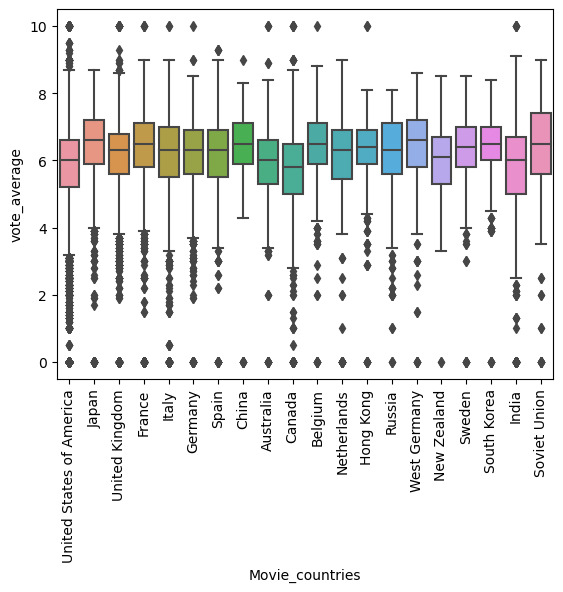

In [27]:
# Plot the distribution of the average votes

ax = sns.boxplot(x="Movie_countries", y="vote_average", data=df_top20_country)

plt.setp(ax.get_xticklabels(), rotation=90);

The distributions seems reasonable, but let us also consider the repartition of the rating among different genres for certain countries as it may differ from one country to another even if there over all rating distribution is similar.

In [28]:
# Select the movies whose genre is within the 20 most common genres (keeping movies from top 20 countries)

top20_genre = movies_fully_expanded['genres'].value_counts()[:20]
df_top20_genre_country = df_top20_country[df_top20_country['genres'].isin(top20_genre.index)]

In [29]:
# Select India, the United Kingdom and the US

df_top20_genre_india = df_top20_genre_country[df_top20_genre_country['Movie_countries']=='India']
df_top20_genre_uk = df_top20_genre_country[df_top20_genre_country['Movie_countries']=='United Kingdom']
df_top20_genre_american = df_top20_genre_country[df_top20_genre_country['Movie_countries']=='United States of America']

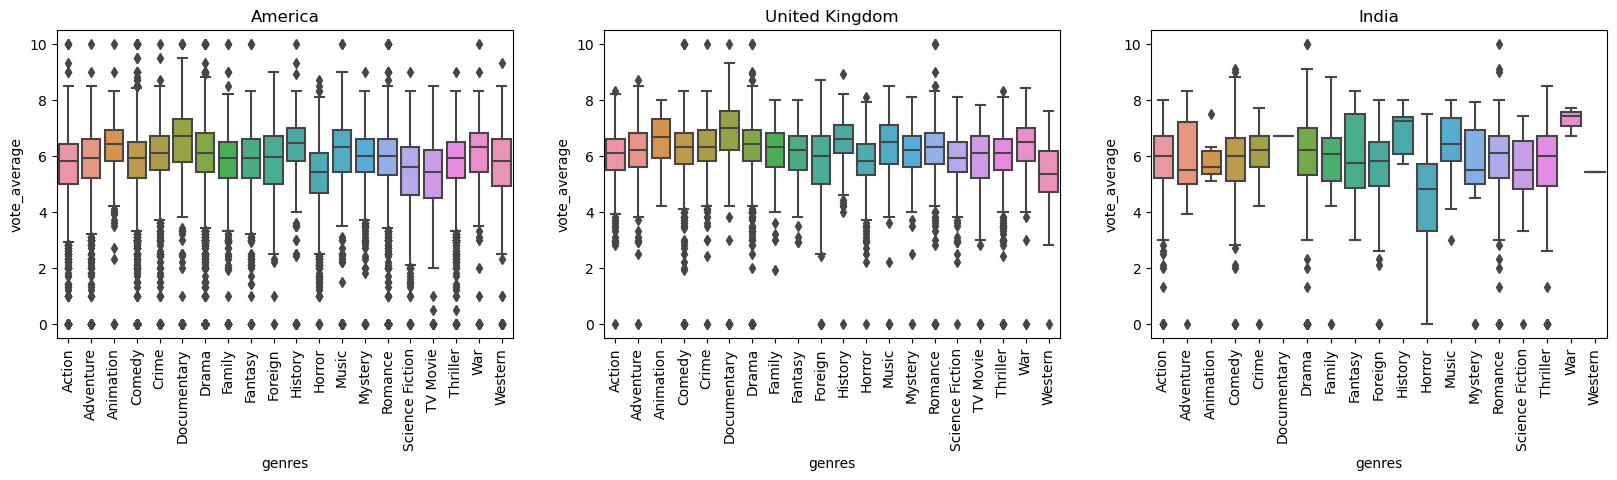

In [30]:
# Plot the distributions
plt.figure(figsize=(20,4))

plt.subplot(1, 3, 1)
plt.title("America")
ax1 = sns.boxplot(x="genres", y="vote_average", data=df_top20_genre_american.sort_values(by='genres'))

plt.subplot(1, 3, 2)
ax2 = sns.boxplot(x="genres", y="vote_average", data=df_top20_genre_uk.sort_values(by='genres'))
plt.title("United Kingdom")

plt.subplot(1, 3, 3)
ax3 = sns.boxplot(x="genres", y="vote_average", data=df_top20_genre_india.sort_values(by='genres'))
plt.title("India")

plt.setp(ax1.get_xticklabels(), rotation=90);
plt.setp(ax2.get_xticklabels(), rotation=90);
plt.setp(ax3.get_xticklabels(), rotation=90);

As one can observe the distributions for the ratings for the different genres are fairly comparable for United Kingdom and America that have similar cultures and national languages, but it differs a lot for India, even if the total average distribtions were comparable to the ones of the two other countries. This is notably because of a smaller amount of data available for the ratings on Indian movies. 

We will also probably have to consider the impact of the production country of a movie over its success given the genre of the movie whenever the amount of data permits it. 

# Casting related feasability of the study

In this section, we aim to explore the feasability of the study focusing on the relationship between a movie's cast and its success in terms of ratings and box office revenues. The aim of this study will be to analyse the relationship between the success of a movie and the number of its actors, their gender repartition, their diversity, etc...

In [287]:
characters.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


We are not going to use the Wikipedia movie id, so let us discard it.

In [288]:
characters.drop('Wikipedia_Movie_ID', axis = 1)

,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
0,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r
...,...,...,...,...,...,...,...,...,...
450664,/m/03pcrp,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c
450665,/m/03pcrp,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_
450666,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc
450667,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj


DataFrame Shape: (450669, 10)

Data Types Counts:
object     7
float64    2
int64      1
Name: count, dtype: int64


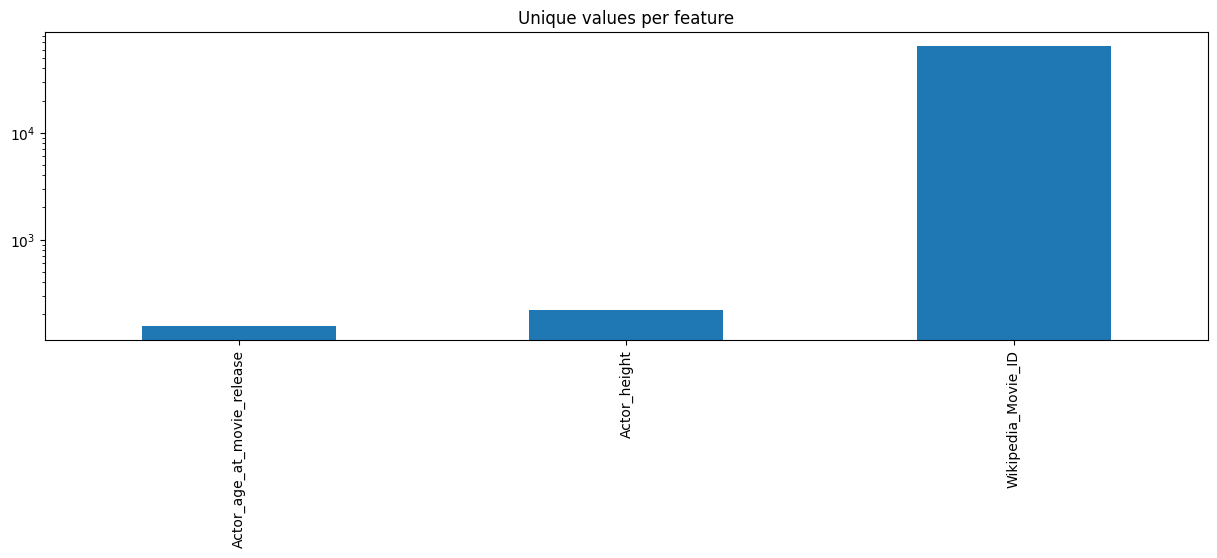

In [289]:
structural_analysis(characters)

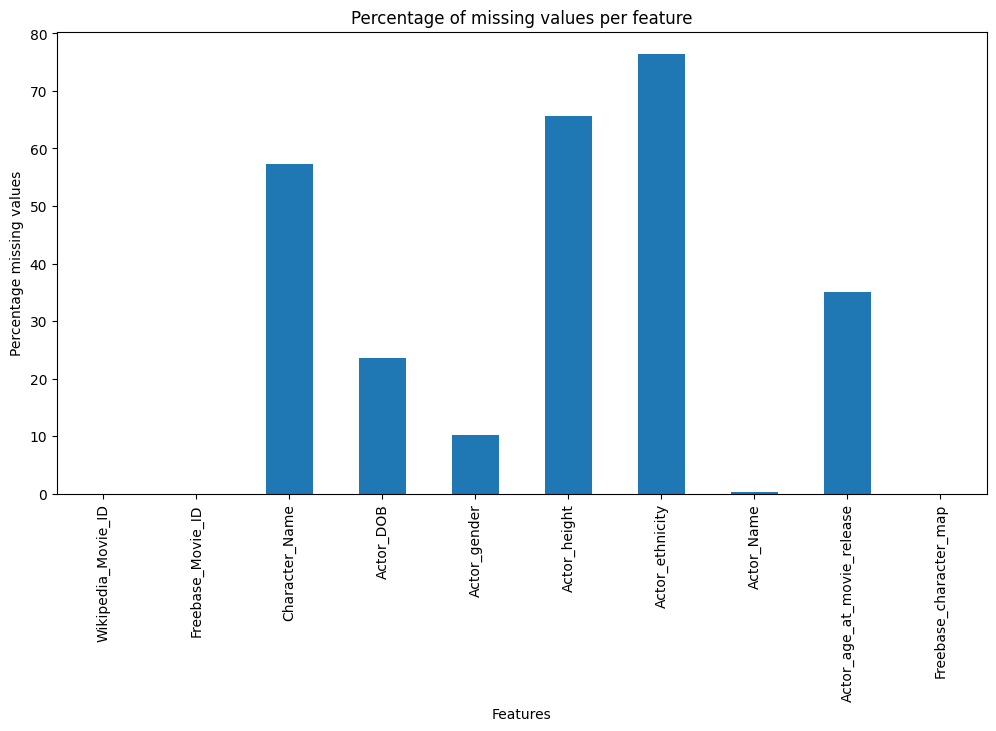

In [290]:
plot_nan(characters, 'Percentage of missing values per feature')

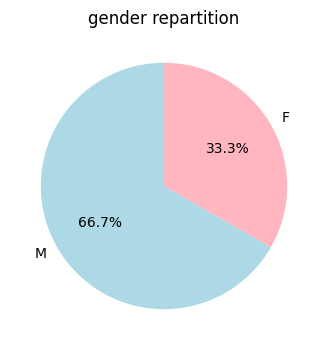

In [291]:
# Counting how many characters of each gender are there
gender_counts = characters['Actor_gender'].value_counts()

# Creating a pie chart
plt.figure(figsize=(4, 4))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink'])
plt.title('gender repartition')
plt.show()

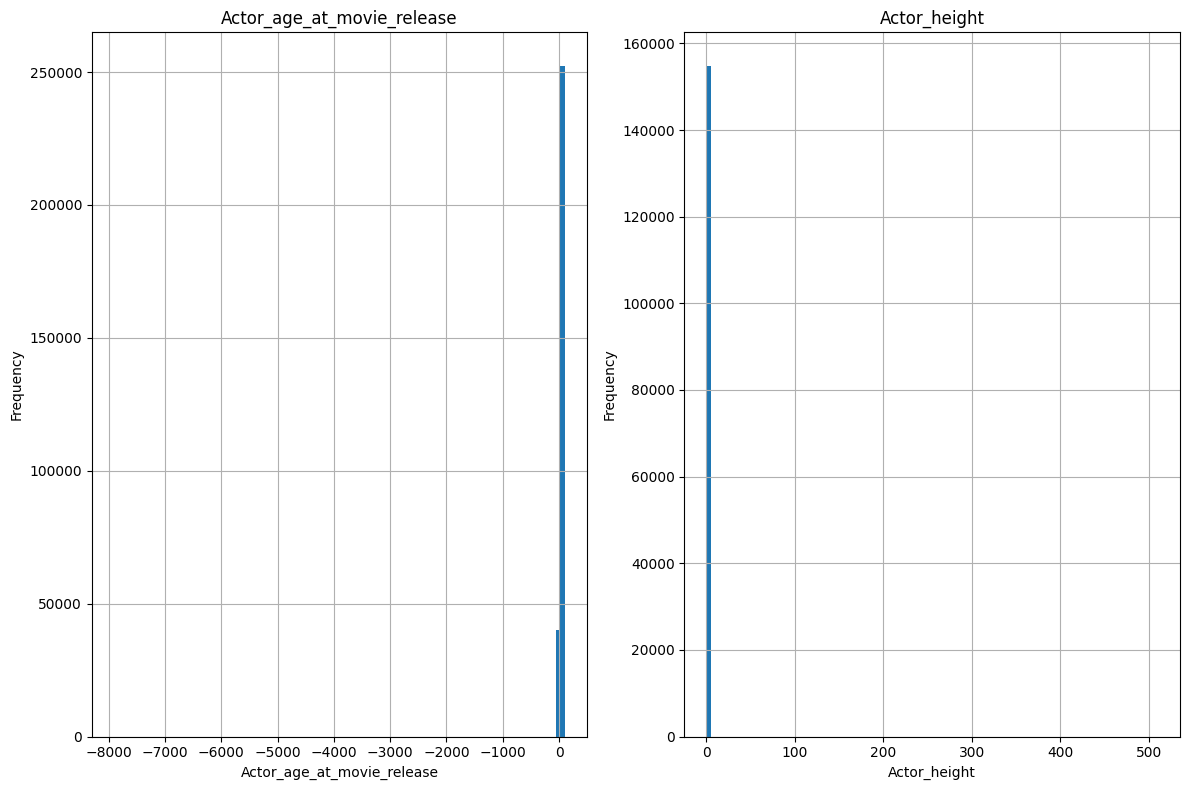

In [292]:
plot_histograms(characters,['Actor_age_at_movie_release','Actor_height'])

We can see that there are some outliers in our data frame, let us remove them and replot them


In [293]:
condition1 = characters['Actor_age_at_movie_release'] < 0 
condition2 = characters['Actor_height'] >=3
characters = characters.drop(characters[condition1].index)
characters = characters.drop(characters[condition2].index)

/var/folders/c6/1b0lb_gj5sscv1_rt1p35drm0000gn/T/ipykernel_2173/540413928.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  characters = characters.drop(characters[condition2].index)


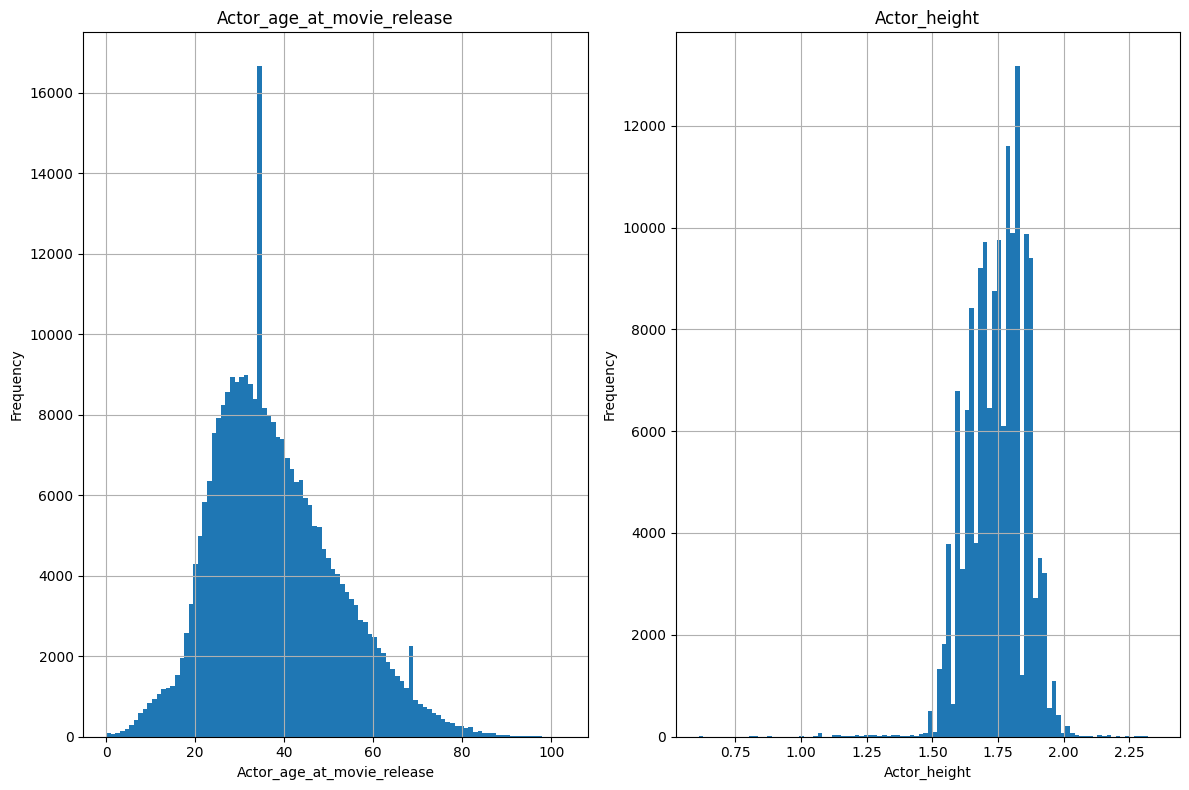

In [295]:
plot_histograms(characters,['Actor_age_at_movie_release','Actor_height'])

We observe that the distributions of the actor ages and heights are much better after the removal of the outliers.

Now, let us see the distribution of the number of actors per movie, meaning, for each movie with a freebase movie id, the number of occurencies of that freebase movie id in the characters dataframe.

In [296]:
characters_in_movies = characters[characters['Freebase_Movie_ID'].isin(movies['Freebase_Movie_ID'])]
len(characters_in_movies)

246417

In [334]:
percentage = (len(characters_in_movies) / len(characters))
print(f"the percentage of charcaters that are represented \
in a movie of our dataset of movies is : {percentage:.2%}")

the percentage of charcaters that are represented in a movie of our dataset of movies is : 54.73%


We see that from our characters dataset, we can use a good portion of it to study the relationship between the casting of a movie and it's box office revenue since 55% of the characters are in one of the movies of our dataset, which is considerable given the size of our dataset.

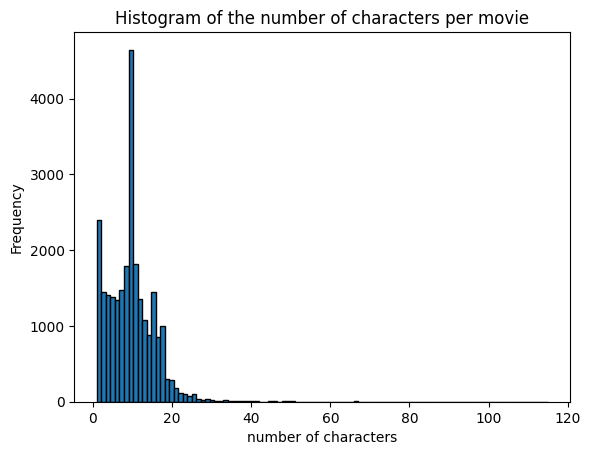

In [298]:
characaters_per_movie = characters_in_movies.groupby('Freebase_Movie_ID').size()
characaters_per_movie.plot(kind='hist', bins=100, edgecolor='black')

plt.title('Histogram of the number of characters per movie')
plt.xlabel('number of characters')
plt.ylabel('Frequency')

# Show the plot
plt.show()

Let us add the number of actors featured in a movie to the movies dataframe.

In [264]:
characaters_per_movie.name = 'number_of_actors'
movies = movies.merge(characaters_per_movie, left_on="Freebase_Movie_ID", right_index=True)

In [265]:
movies.describe()

,vote_average,vote_count,Movie_box_office_revenue,Movie_runtime,number_of_actors
count,25746.000000,25746.000000,8.982000e+03,24784.000000,25746.000000
mean,5.846077,141.579779,4.959183e+07,101.307002,9.571079
std,1.523681,548.384005,1.158964e+08,27.330694,5.796700
min,0.000000,0.000000,1.000000e+00,0.000000,1.000000
25%,5.300000,5.000000,2.200000e+06,90.000000,5.000000
50%,6.100000,15.000000,1.120574e+07,98.000000,9.000000
75%,6.800000,54.000000,4.203257e+07,110.000000,13.000000
max,10.000000,14075.000000,2.782275e+09,1003.000000,115.000000


Let us take a look at the fraction of female actors for each movie

In [320]:
male_characters = characters[characters['Actor_gender'] == 'M']
number_of_male_actors = male_characters.groupby('Freebase_Movie_ID').size()
number_of_male_actors

female_characters = characters[characters['Actor_gender'] == 'F']
number_of_female_actors = female_characters.groupby('Freebase_Movie_ID').size()
number_of_female_actors

fraction_of_female_actors = 100 *(number_of_female_actors / characaters_per_movie)
fraction_of_female_actors


0


Freebase_Movie_ID
/m/011_mj    11.111111
/m/011_p6    40.000000
/m/011_zy          NaN
/m/011wtv    33.333333
/m/011x_4    25.000000
               ...    
/m/0yyn5     43.750000
/m/0yyts     40.000000
/m/0yzbg     23.076923
/m/0yzp8     30.769231
/m/0yzvw     30.769231
Length: 54364, dtype: float64

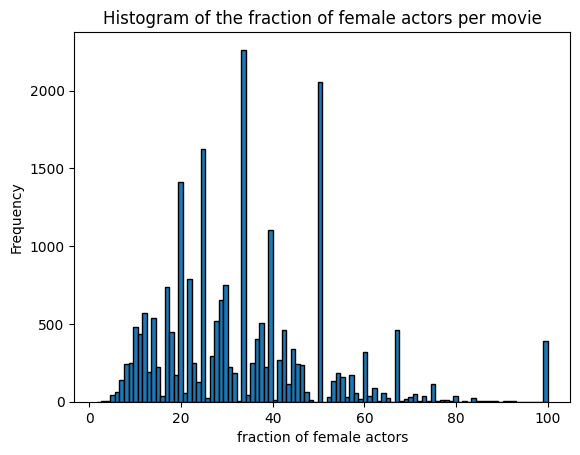

In [316]:
fraction_of_female_actors.plot(kind='hist', bins=100, edgecolor='black')

plt.title('Distribution of the frequency of female actors in movies')
plt.xlabel('fraction of female actors')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [322]:
fraction_of_female_actors.name = 'fraction_of_female_actors'
movies = movies.merge(fraction_of_female_actors, left_on="Freebase_Movie_ID", right_index=True)

In [327]:
movies.head(20)

,budget,genres,imdb_id,popularity,production_countries,release_date,spoken_languages,vote_average,vote_count,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,fraction_of_female_actors
0,30000000,"[Animation, Comedy, Family]",tt0114709,21.946943,[United States of America],1995-10-30,[English],7.7,5415.0,/m/0dyb1,Toy Story,361958736.0,77.0,[English Language],[United States of America],"[Buddy film, Adventure, Children's/Family, Com...",23.076923
1,65000000,"[Adventure, Fantasy, Family]",tt0113497,17.015539,[United States of America],1995-12-15,"[English, Français]",6.9,2413.0,/m/09w353,Jumanji,262797249.0,104.0,"[French Language, English Language]","[United States of America, Japan]","[Thriller, Fantasy Adventure, Japanese Movies,...",37.500000
2,0,"[Romance, Comedy]",tt0113228,11.7129,[United States of America],1995-12-22,[English],6.5,92.0,/m/0676dr,Grumpier Old Men,71518503.0,101.0,"[Italian Language, English Language]",[United States of America],"[Romantic comedy, Buddy film, Comedy]",50.000000
3,16000000,"[Comedy, Drama, Romance]",tt0114885,3.859495,[United States of America],1995-12-22,[English],6.1,34.0,/m/03vny7,Waiting to Exhale,81452156.0,121.0,[English Language],[United States of America],"[Ensemble Film, Female buddy film, Comedy-dram...",42.857143
4,0,[Comedy],tt0113041,8.387519,[United States of America],1995-02-10,[English],5.7,173.0,/m/094g2z,Father of the Bride Part II,76594107.0,106.0,[English Language],[United States of America],"[Screwball comedy, Romance Film, Family Film, ...",50.000000
5,60000000,"[Action, Crime, Drama, Thriller]",tt0113277,17.924927,[United States of America],1995-12-15,"[English, Español]",7.7,1886.0,/m/0bxsk,Heat,187436818.0,170.0,"[English Language, Spanish Language]",[United States of America],"[Thriller, Crime Fiction, Heist, Psychological...",21.052632
6,58000000,"[Comedy, Romance]",tt0114319,6.677277,"[Germany, United States of America]",1995-12-15,"[Français, English]",6.2,141.0,/m/04wdfw,Sabrina,53458319.0,127.0,[English Language],[United States of America],"[Romantic comedy, Romance Film, Drama, Comedy]",61.538462
7,0,"[Action, Adventure, Drama, Family]",tt0112302,2.561161,[United States of America],1995-12-22,"[English, Deutsch]",5.4,45.0,/m/031hvc,Tom and Huck,23920048.0,92.0,[English Language],[United States of America],"[Adventure, Children's/Family, Costume drama, ...",25.000000
8,35000000,"[Action, Adventure, Thriller]",tt0114576,5.23158,[United States of America],1995-12-22,[English],5.5,174.0,/m/0bcy50,Sudden Death,64350171.0,111.0,[English Language],[United States of America],"[Thriller, Action/Adventure, Action, Drama]",31.250000
9,58000000,"[Adventure, Action, Thriller]",tt0113189,14.686036,"[United Kingdom, United States of America]",1995-11-16,"[English, Pусский, Español]",6.6,1194.0,/m/01npcx,GoldenEye,356400000.0,130.0,"[Russian Language, English Language, Spanish L...","[United States of America, United Kingdom]","[Thriller, Action Thrillers, Adventure, Action...",38.888889


We hence observe that we have enough data to perform our analysis regarding the relationsip between the casting of a movie and its success, which we will perform during milestone p3